In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

file_path = 'SpotifyFeatures.csv'
data = pd.read_csv(file_path)
data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [13]:
# Handle outliers in the dataset
# remove song that are to long in duration songs longer than 500000 ms (500 seconds = 8.3 minutes)

data.head()
data = data[data['duration_ms'] < 500000]
data = data[data["loudness"] > -30]


#SPEECH PER GENRE



In [14]:
# Function to convert pitch to number
def pitch_to_number(pitch):
    pitch_map = {
        'C': 0,
        'C#': 1, 'Db': 1,
        'D': 2,
        'D#': 3, 'Eb': 3,
        'E': 4, 'Fb': 4,
        'E#': 5, 'F': 5,
        'F#': 6, 'Gb': 6,
        'G': 7,
        'G#': 8, 'Ab': 8,
        'A': 9,
        'A#': 10, 'Bb': 10,
        'B': 11, 'Cb': 11
    }
    return pitch_map.get(pitch, None)

# Replace the pitch column with its numeric representation
# Assuming the column name in your DataFrame that contains pitch values is 'pitch_column'
data['key'] = data['key'].apply(pitch_to_number)


In [15]:
# Convert the mode column to 1 for major and 0 for minor
data['mode'] = data['mode'].replace("Minor", 0)
data['mode'] = data['mode'].replace("Major", 1)

data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,1,0.3460,-1.828,1,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,6,0.1510,-5.559,0,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,0,0.1030,-13.879,0,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,1,0.0985,-12.178,1,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,5,0.2020,-21.150,1,0.0456,140.576,4/4,0.390


In [16]:
# group by genre
grouped = data.groupby('genre')
#print(grouped.size())

# Group by genre and calculate mean popularity
grouped = data.groupby('genre')
mean_popularity = grouped['popularity'].mean()

# Function to label rows as 'popular' or 'nonpopular'
def label_popularity(row, mean_popularity):
    if row['popularity'] >= mean_popularity[row['genre']]:
        return 'popular'
    else:
        return 'nonpopular'

# Apply the function to each row
data['popularity_label'] = data.apply(lambda row: label_popularity(row, mean_popularity), axis=1)

# Splitting the data into popular and nonpopular, ensuring each genre is split 50/50
# This step might require adjusting the labels for genres with an odd number of entries
for genre in data['genre'].unique():
    genre_data = data[data['genre'] == genre]
    n = len(genre_data) // 2
    popular_indices = genre_data.nlargest(n, 'popularity').index
    nonpopular_indices = genre_data.nsmallest(n, 'popularity').index
    data.loc[popular_indices, 'popularity_label'] = 'popular'
    data.loc[nonpopular_indices, 'popularity_label'] = 'nonpopular'

data.head()  # Display the first few rows of the modified DataFrame





,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity_label
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,1,0.3460,-1.828,1,0.0525,166.969,4/4,0.814,nonpopular
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,6,0.1510,-5.559,0,0.0868,174.003,4/4,0.816,nonpopular
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,0,0.1030,-13.879,0,0.0362,99.488,5/4,0.368,nonpopular
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,1,0.0985,-12.178,1,0.0395,171.758,4/4,0.227,nonpopular
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,5,0.2020,-21.150,1,0.0456,140.576,4/4,0.390,nonpopular


<AxesSubplot: xlabel='genre'>

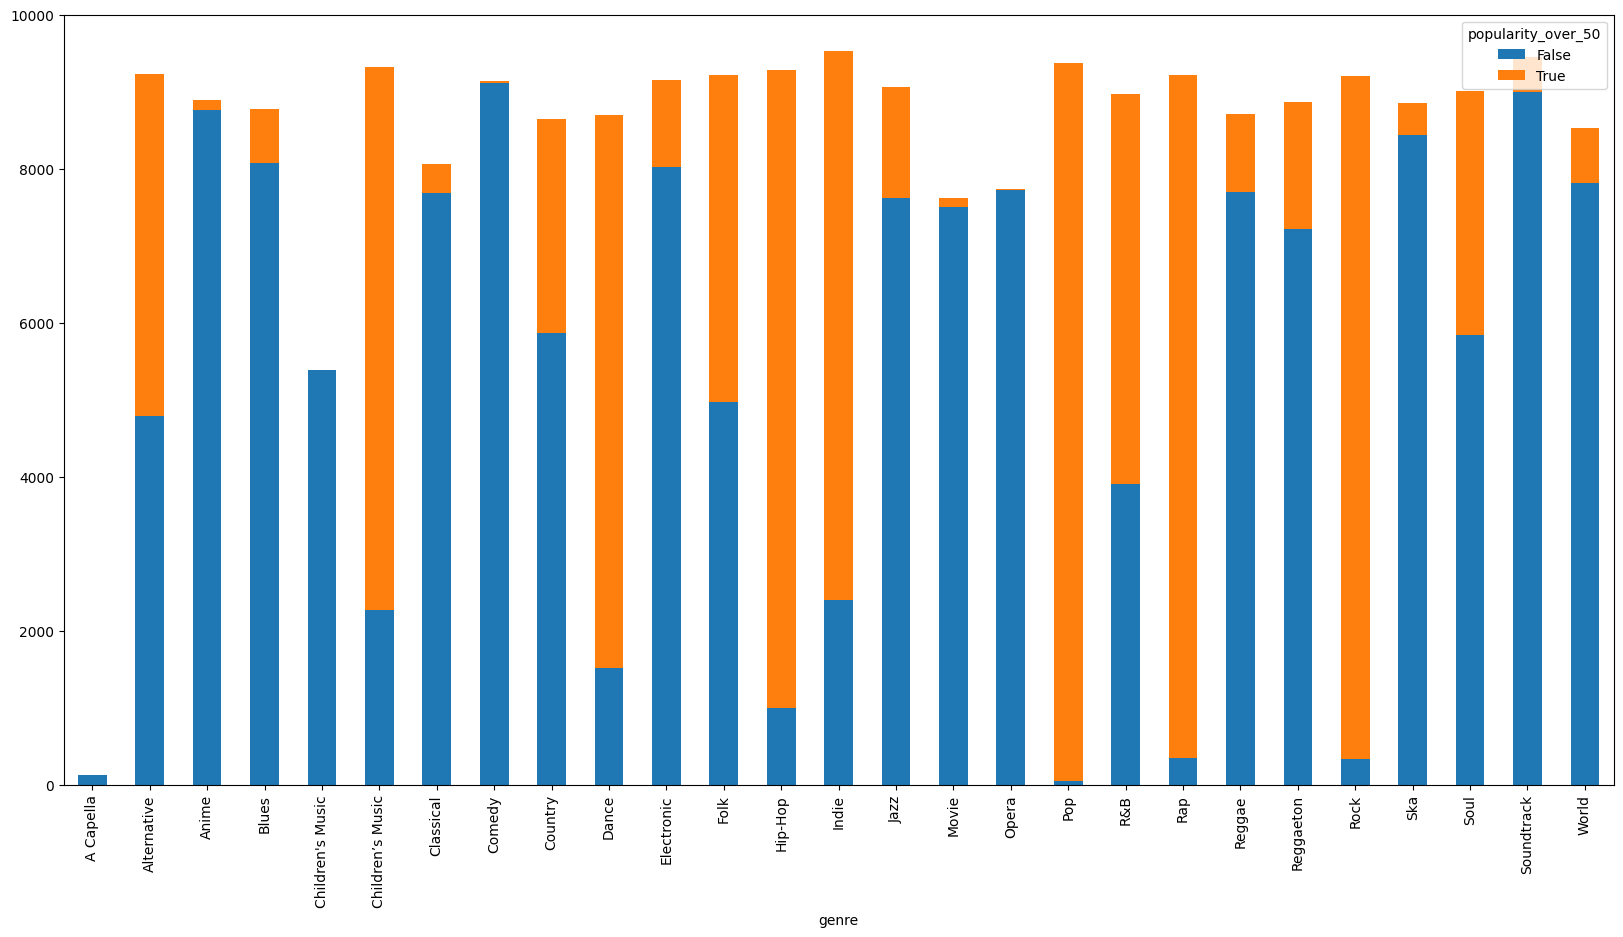

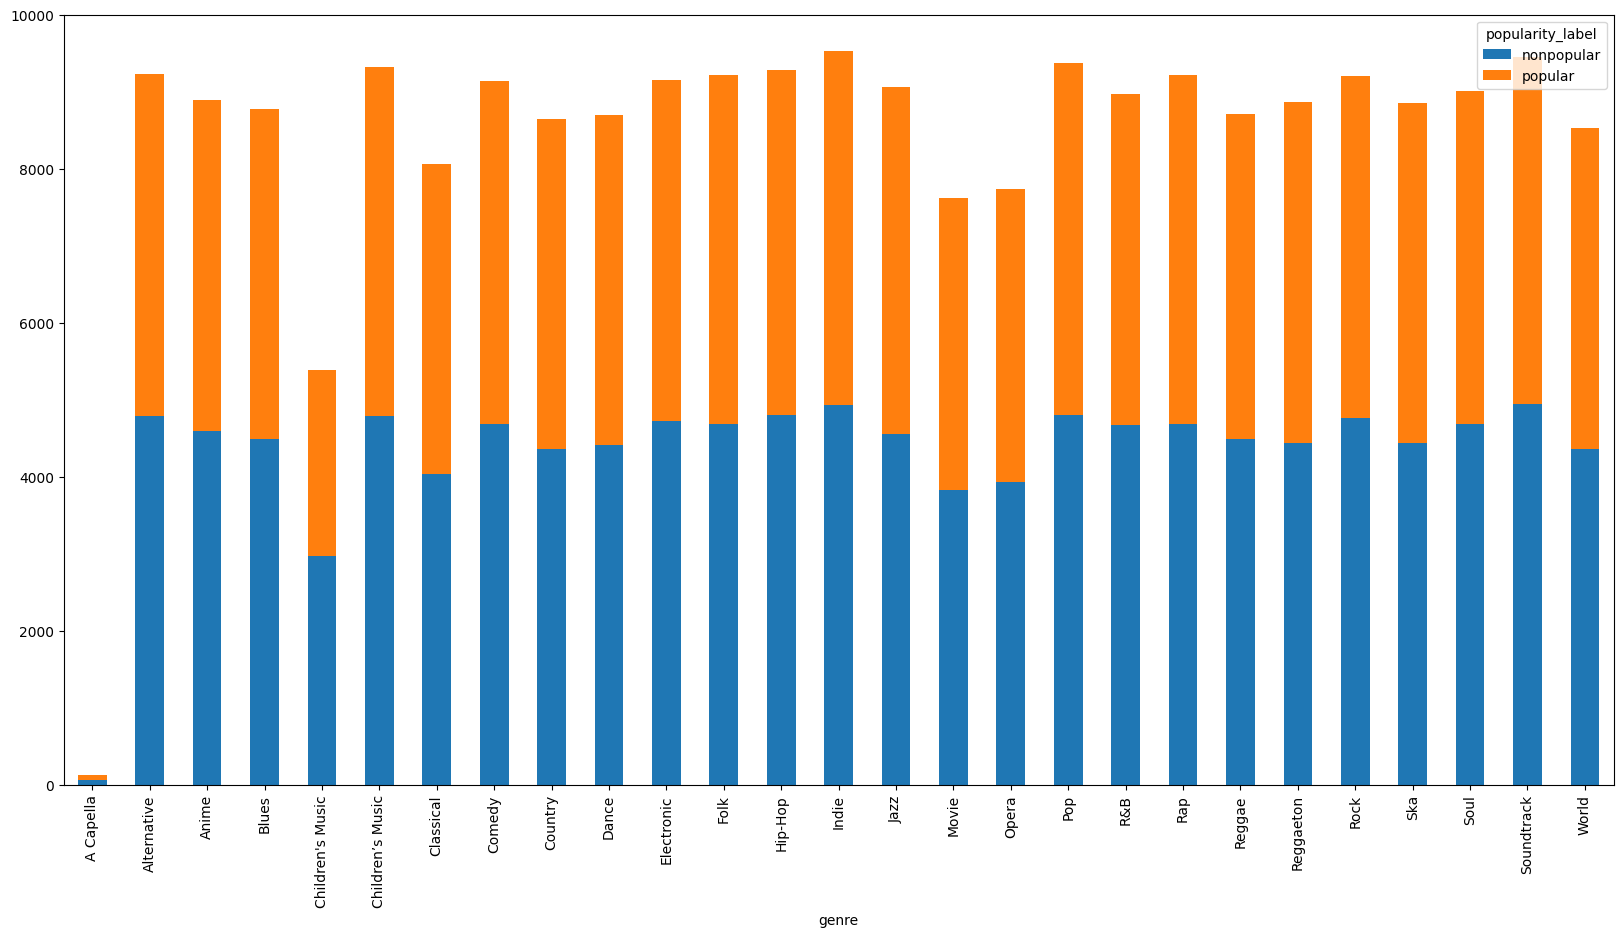

In [40]:
# split data by genre
data['genre'].unique()
data['genre'].value_counts()


# create new column for popularity over 50
data['popularity_over_50'] = data['popularity'] >= 50
data['popularity_over_50'].value_counts()

# create table graph for every genre and popularity over 50


data.groupby(['genre', 'popularity_over_50']).size().unstack().plot(kind='bar', stacked=True, figsize=(20, 10))

# make one but with nonpopular and popular
data.groupby(['genre', 'popularity_label']).size().unstack().plot(kind='bar', stacked=True, figsize=(20, 10))



In [17]:
# Calculate and print the splitting point (mean popularity) for every genre
splitting_points = mean_popularity.to_dict()
splitting_points


{'A Capella': 9.302521008403362,
 'Alternative': 50.21418516513265,
 'Anime': 24.26040026984484,
 'Blues': 34.79808459696728,
 "Children's Music": 4.25459268881054,
 'Children’s Music': 54.665951512550954,
 'Classical': 29.53426017874876,
 'Comedy': 21.242782152230973,
 'Country': 46.097907756328745,
 'Dance': 57.27784169351128,
 'Electronic': 38.049721341929846,
 'Folk': 49.95996962464743,
 'Hip-Hop': 58.422873773849304,
 'Indie': 54.706981627296585,
 'Jazz': 40.84872558755379,
 'Movie': 12.295499278309933,
 'Opera': 13.341264709685762,
 'Pop': 66.59140358361775,
 'R&B': 52.318956870611835,
 'Rap': 60.5366250678242,
 'Reggae': 35.60999425617461,
 'Reggaeton': 37.76805869074492,
 'Rock': 59.636353759235114,
 'Ska': 28.61764373658647,
 'Soul': 47.02853019538188,
 'Soundtrack': 33.932797121388504,
 'World': 35.558174994135584}

In [18]:

from sklearn.model_selection import train_test_split




# for each genre, make random forest classifier
from sklearn.ensemble import RandomForestClassifier

# Create a dictionary of classifiers, one for each genre, random forest classifier
classifiers = {}



# Create a classifier for each genre
for genre in data['genre'].unique():
    # Create a new DataFrame containing only the current genre
    genre_data = data[data['genre'] == genre]
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(genre_data[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']], genre_data['popularity_label'], test_size=0.2)
    # Create a random forest classifier
    classifier = RandomForestClassifier(n_estimators=100)
    # Train the classifier
    classifier.fit(X_train, y_train)
    # Add the classifier to the dictionary of classifiers
    classifiers[genre] = classifier

    # add accuracy score to dictionary
    classifiers[genre] = classifier.score(X_test, y_test)

    

# Print the dictionary of classifiers
classifiers



{'Movie': 0.6609836065573771,
 'R&B': 0.5337047353760446,
 'A Capella': 0.6666666666666666,
 'Alternative': 0.5224688684353005,
 'Country': 0.5257076834199884,
 'Dance': 0.542840713053479,
 'Electronic': 0.5734571272528672,
 'Anime': 0.6020236087689713,
 'Folk': 0.5249457700650759,
 'Blues': 0.5367521367521367,
 'Opera': 0.5520361990950227,
 'Hip-Hop': 0.5598060344827587,
 "Children's Music": 0.647495361781076,
 'Children’s Music': 0.5201072386058981,
 'Rap': 0.5317417254476398,
 'Indie': 0.5585301837270341,
 'Classical': 0.6035980148883374,
 'Pop': 0.5319829424307037,
 'Reggae': 0.5605973578403216,
 'Reggaeton': 0.5919864559819413,
 'Jazz': 0.5912851627137341,
 'Rock': 0.4991852254209669,
 'Ska': 0.5584415584415584,
 'Comedy': 0.6260251503553854,
 'Soul': 0.5127635960044395,
 'Soundtrack': 0.5259259259259259,
 'World': 0.5468933177022274}

In [19]:
# print avg accuracy score
avg = 0
for genre in classifiers:
    avg += classifiers[genre]
avg /= len(classifiers)
print(avg)


0.5632574950812177


In [20]:




# for each genre, make random forest classifier
from sklearn.ensemble import GradientBoostingClassifier

# Create a dictionary of classifiers, one for each genre, random forest classifier
classifiers = {}



# Create a classifier for each genre
for genre in data['genre'].unique():
    # Create a new DataFrame containing only the current genre
    genre_data = data[data['genre'] == genre]
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(genre_data[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']], genre_data['popularity_label'], test_size=0.2)
    # Create a random forest classifier
    classifier = GradientBoostingClassifier(n_estimators=100)
    # Train the classifier
    classifier.fit(X_train, y_train)
    # Add the classifier to the dictionary of classifiers
    classifiers[genre] = classifier

    # add accuracy score to dictionary
    classifiers[genre] = classifier.score(X_test, y_test)

    

# Print the dictionary of classifiers
classifiers



{'Movie': 0.6518032786885246,
 'R&B': 0.5454038997214484,
 'A Capella': 0.5833333333333334,
 'Alternative': 0.5349214943151056,
 'Country': 0.5280184864240324,
 'Dance': 0.5589419206440484,
 'Electronic': 0.5767340251228836,
 'Anime': 0.6025857223159078,
 'Folk': 0.5281995661605207,
 'Blues': 0.5663817663817664,
 'Opera': 0.5746606334841629,
 'Hip-Hop': 0.5689655172413793,
 "Children's Music": 0.634508348794063,
 'Children’s Music': 0.5447721179624665,
 'Rap': 0.5268583830710798,
 'Indie': 0.5606299212598426,
 'Classical': 0.6023573200992556,
 'Pop': 0.5250533049040512,
 'Reggae': 0.5439402642159679,
 'Reggaeton': 0.5829571106094809,
 'Jazz': 0.5841147269718698,
 'Rock': 0.5263443780554047,
 'Ska': 0.554488989271598,
 'Comedy': 0.6293056314926189,
 'Soul': 0.5338512763596004,
 'Soundtrack': 0.5338624338624338,
 'World': 0.5404454865181711}

In [21]:
# print avg accuracy score
avg = 0
for genre in classifiers:
    avg += classifiers[genre]
avg /= len(classifiers)
print(avg)


0.5645718273067044


In [22]:
# Calculate and print the size difference between nonpopular and popular for each genre
size_difference = data.groupby(['genre', 'popularity_label']).size().unstack().fillna(0)
size_difference['difference'] = size_difference['popular'] - size_difference['nonpopular']
size_difference


popularity_label,nonpopular,popular,difference
genre,,,
A Capella,62,57,-5
Alternative,4783,4452,-331
Anime,4596,4298,-298
Blues,4491,4280,-211
Children's Music,2963,2426,-537
Children’s Music,4794,4528,-266
Classical,4028,4028,0
Comedy,4689,4455,-234
Country,4358,4293,-65
